# Sprint II B - MACHINE LEARNING & ANALYTICS
## Data Science & Analytics - PUC Rio

### Francisco das Chagas Alves Freitas
Jul, 23. 2023 Teresina, PI

# 1 Descrição do Problema
O problema de classificação utilizando o dataset CIFAR-10 consiste em categorizar imagens em dez classes distintas: avião, carro, pássaro, gato, veado, cachorro, sapo, cavalo, navio e caminhão.

O CIFAR-10 é composto por um conjunto de 60.000 imagens coloridas de dimensão 32x32 pixels, divididas igualmente entre as classes, sendo 50.000 imagens para treinamento e 10.000 para teste. Esse dataset é amplamente utilizado na área de visão computacional e aprendizado de máquina, permitindo a avaliação de algoritmos de classificação em um cenário desafiador, devido ao seu tamanho relativamente pequeno e às imagens de baixa resolução, o que requer a extração de características discriminativas para uma correta categorização.

O objetivo do problema é desenvolver um modelo de classificação capaz de atribuir corretamente as categorias às imagens de teste com a maior precisão possível.

Para facilitar o acesso e manipulação dos dados, a base de dados CIFAR10 é carregada utilizando a função cifar10.load_data() e, em seguida, os dados são pré-processados normalizando as intensidades dos pixels para o intervalo entre 0 e 1.

Mais detalhes em https://keras.io/api/datasets/cifar10/.

# 2 Preparação dos Dados


In [ ]:
# Importanção das bibliotecas necessárias para a execução deste notebook.

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10 # Realiza a importação das 60.000 imagens do CIFAR10.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import utils

import sklearn.metrics as skm

from sklearn.metrics import confusion_matrix, classification_report

import itertools

from datetime import datetime

import matplotlib.pyplot as plt # inicialmente para plotar a matriz de confusão.


## 1.1 Funções Helpers

Abaixo é definida a função plot_confusion_matrix() paga gerar uma **Matriz de Confusão**.

Com base na matriz de confusão, é possível calcular várias métricas de desempenho, como a **precisão**, a sensibilidade (recall), a especificidade e a **taxa de acerto (accuracy)**, entre outras, para avaliar a performance do modelo e ajustá-lo, se necessário. Essas métricas fornecem insights sobre o quão bem o modelo está realizando a tarefa de classificação.

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

## 1.2 Carregamento dos Dados

Como citado anteriormente, neste projeto será utilizada a base de dados CIFAR10 fornecida pelo [Keras](https://keras.io/). Abaixo é realizado o download do dataset em duas Tuplas, cada uma com um par de Arrays representando as matrizes das imagens. Segue a descrição detalhada de cada array:

**x_train:** uint8 matriz NumPy de dados de imagem em tons de cinza com formas (50000, 32, 32, 3), contendo os dados de treinamento. Os valores de pixel variam de 0 a 255.

**y_train:** uint8 matriz NumPy de rótulos (inteiros no intervalo de 0 a 9) com formato (50000, 1) para os dados de treinamento.

**x_test:** uint8 Matriz NumPy de dados de imagem em tons de cinza com formas (10000, 32, 32, 3), contendo os dados de teste. Os valores de pixel variam de 0 a 255.

**y_test:** uint8 Matriz NumPy de rótulos (inteiros no intervalo de 0 a 9) com forma (10000, 1) para os dados de teste.

In [ ]:
# Carregar a base de dados CIFAR10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print('Shape do x_train: {}'.format(x_train.shape))
print('Shape do x_test: {}'.format(x_test.shape))
print('Shape do y_train: {}'.format(y_train.shape))
print('Shape do y_test: {}'.format(y_test.shape))

## 1.3 Configuração de Parâmetros

Abaixo, são configurados alguns parâmetros relacionados ao datasete CIFAR10 a serem utilizados nas epatas seguintes.

In [ ]:
# Definação do tamanho do batch e as dimensões das imagens
batch_size = 32
img_height = 32 # altura das imagens no CIFAR10
img_width = 32 # largura das imagens no CIFAR10
num_classes = 10 # imagens distribuídas em 10 classes.

## 1.4 Pré-Processamento

Primeiro vamos realizar a Normalização das imagens. Nesse método, os valores dos pixels da imagem são ajustados para estarem no intervalo [0, 1], dividindo cada valor pelo valor máximo possível de um pixel (255, no caso de uma imagem em escala de cinza ou com 8 bits por canal). Isso permite que os valores dos pixels sejam representados como frações entre 0 e 1, tornando o treinamento de algoritmos mais estável e acelerando a convergência.

Em seguida o método **One Hot Encoding**. O método consiste em transformar, a princípio, uma variável categórica em um vetor binário, onde cada categoria é representada por uma única dimensão. Neste projeto, os valores assumirão valores entre 0 e 9, representando cada categoria de imagem.

In [ ]:
# Pré-processamento dos dados

# Normalização
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# hot encoding
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

## 1.5 Data Augmentation

Essa abordagem tem como objetivo aumentar a quantidade e diversidade dos dados de treinamento, melhorando a capacidade do modelo de generalizar e lidar com variações presentes nos dados reais.

Diferentemente dos exemplos apresentados em sala de aula, o código para a geração de imagens utiliza a função **flow()** no lugar de **flow_from_directory()**.

A documentação da flow() pode ser encontrada em: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow(x_train, y_train_he, batch_size=32, subset='training')

val_generator  = datagen.flow(x_train, y_train_he, batch_size=8, subset='validation')

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)


# 3 Modelagem e Treinamento


## 3.1 Criando Instância do Modelo

Em seguida, um modelo de rede neural convolucional é definido usando a API Sequencial do Keras. Esse modelo consiste em **camadas convolucionais**, duas camadas de **Pooling**, duas de **Dropout** e uma camada **Flatten** para transformar a saída em um vetor unidimensional e uma camada densa final com ativação **Softmax** para realizar a classificação em 10 classes (correspondentes às 10 categorias do CIFAR10).

In [ ]:
# Definir o modelo 3 de rede neural
model = keras.Sequential(
    [
      keras.Input(shape=(32, 32, 3)),
      layers.Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'),
      layers.MaxPool2D(pool_size=(2,2)),
      layers.Dropout(0.25), # Drop 25% of the units from the layer.

      layers.Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'),
      layers.MaxPool2D(pool_size=(2,2)),
      layers.Dropout(0.25),

      layers.Flatten(),

      layers.Dense(256,activation='relu'),
      layers.Dense(10,activation='softmax'),
  ]
)

O modelo é compilado com a função de perda **categorical_crossentropy**, o otimizador **ADAM** e a *métrica de acurácia*.

In [ ]:
# Compilar o modelo
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## 3.2 Resumo do Modelo Compilado

In [ ]:
model.summary()

## 3.3 Treino do Modelo

Após compilar o modelo, ele é treinado usando o método **fit()**. Nesse exemplo, são realizadas **20 épocas** de treinamento com 10% dos dados de treinamento (10.000 imagens de 32x32) são usados como conjunto de validação.

NOTA: não foi necessário a utilização do parãmetro **batch_size**.

In [ ]:
# Pré treino do modelo
epochs=20

# Treinar o modelo
#model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_split=0.1)

# Treinar o modelo. Nota: o modelo acime é um exemplo do professor.
history = model.fit(x_train, y_train_cat,
          validation_data=(x_test, y_test_cat),
          epochs=epochs)

# 4 Avaliação de Resultados


## 4.1 Verificação da Acurária do Modelo

Por fim, o modelo é avaliado no conjunto de teste utilizando o método evaluate() e a acurácia do modelo é impressa logo em seguida.

Quando esta estapa foi realizada, os resultados foram os seguintes:

- **Loss:** 0.9542;
- **Accuracy:** 0.6883 (68,9%).

In [ ]:
#y_test.shape
# Avaliar o modelo
#_, accuracy = model.evaluate(x_test, y_test)
#print("Acurácia no conjunto de teste:", accuracy)

# Avaliação do modelo com o conjunto de testes
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat)
print(f'Test accuracy: {test_accuracy}')


O método model.fit() retorna um obejto history, contendo informações relevantes sobre o treinamento do modelo e pode ser usado para analisar o desempenho da CNN ao longo das épocas (iterações) de treinamento.

As informações obtidas foram plotadas na próxima célula de código utlizando pyplot. Uma breve descrição de cada uma das informações segue abaixo:

**Loss** ou Perda: É uma medida do quão bem o modelo está aprendendo durante o treinamento. O objetivo é minimizar essa perda para que o modelo se ajuste aos dados de treinamento.

Accuracy ou Precisão: Representa a acurácia do modelo durante o treinamento, ou seja, a proporção de amostras classificadas corretamente em relação ao total.

Validation Loss ou Perda de Validação: É a perda calculada usando um conjunto de dados de validação separado, que não foi usado no treinamento. Ajuda a monitorar se o modelo está sofrendo de **overfitting**.

Validation Accuracy ou Precisão de Validação: Representa a acurácia do modelo em relação aos dados de validação.

<Axes: >

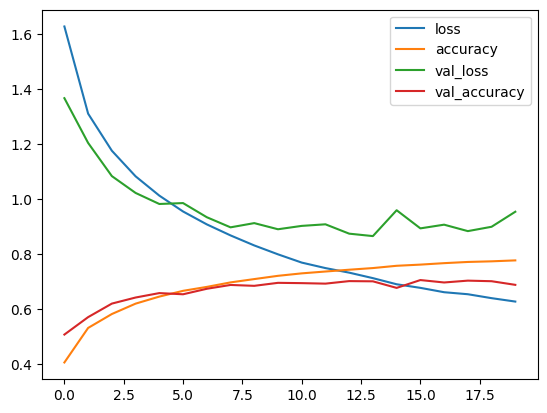

In [ ]:
pd.DataFrame(history.history).plot()

## 4.2 Execução do Modelo com Visualizações

Abaixo deve apresentar as imagens com a label e a respectiva predição com a porcentagem de acorto do modelo.

Antes disso o conjunto de testes é normalizado utilizando o mésmo método da seção de pré-processamento. Em seguida, os dados normalizados são utilizados na função model.predict() para realizar as predições com base na base de testes normalizada.

In [ ]:
# Normalizar as imagens
x_test_norm = x_test.astype('float32') / 255.0

# Obter as previsões do modelo para as imagens de teste
predictions = model.predict(x_test_norm)

In [ ]:
# Mapear os índices das classes para os rótulos de texto
labels = [
    'Avião', 'Automóvel', 'Pássaro', 'Gato', 'Cervo',
    'Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão'
]

Na célula de cógigo abaixo são criadas duas listas, uma para os valores preditos dentro da variável predictions e outra com os valores reais encontrados no conjunto de dados.

Em seguida, um laço for itera sobre as 10.000 imagens do conjunto de testes e armazena nas listas os valores preditos e os reais. Em adição, as respectivas imagens são exibidas, assim como os valores reais, previstos e probabilidade no título de cada imagem.

In [ ]:
y_pred = list()
y_true = list()

# Visualizar algumas imagens com suas previsões
num_images = 10000

for i in np.arange(0, num_images):
    # Obter a classe real e a previsão do modelo para a imagem
    real_class = labels[y_test[i][0]]
    predicted_class = labels[np.argmax(predictions[i])]

    #y_true.append(real_class)
    y_true.append(real_class)
    #y_pred.append(predicted_class)
    y_pred.append(predicted_class)

    probability = predictions[i][np.argmax(predictions[i])]
    # Visualizar a imagem
    plt.imshow(x_test[i])
    plt.title(f'Real: {real_class}, Previsto: {predicted_class}, Probabilidade: {probability}')
    plt.axis('off')
    plt.show()


## 4.3 Visualização das Métricas

No momento em que executei este notebook, os valores encontrados foram:

In [ ]:
# Calculando as métricas
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

## 4.4 Matriz de Confusão

Também conhecida como tabela de contingência, é utilziada para avaliar o desempenho de um modelo de classificação. Ela permite visualizar a eficácia de um algoritmo ao comparar suas previsões com as classes reais do conjunto de dados. A matriz de confusão possui dimensões iguais ao número de classes do problema.

Na célula de código seguinte, executo a função plot_confusion_matrix() definida na seção 1.1 deste notebook.



In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=labels,
                      normalize= False,
                      title='Matriz real x predição')

## 4.5

In [ ]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = 'trained_models'

name_model = 'cifar10_' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

## 4.6 Resultados

Como resultado do presente trabalho, o modelo definido na Seção 3 (Modelagem e Treinamento) utilizando as configuração apresentadas, teve o melhor desempenho em relação às tentativas anteriores.

O método de Data Augmentation não se mostrou eficaz, aumentando a perda e a perda de validação.

A quantidade de *epochs=20* utiliada neste notebook se mostrou a melhor até o momento utilizando as configurações definidas.

Como pôde ser observado na Matriz de Confusão, mesmo com uma acurácia de ~68% a diagonal mostra o quão bem o modelo aprendeu a diferenciar as classes na maioria dos casos. Isso pode ser justificado pela ausência de overfitting, caraterizado pelo baixo valor na perda de validação (até o momento desta execução, foi de 0,95).

Para conseguir melhores desempenhos, serão necessárias: a adição de mais camadas com diferentes arquiteturas; tentar novamente o método de data augmentation; possivelmente a variação das epochs durante o fit do modelo; etc.